# Time Series Modeling Lesson

In this lesson, we will practice forecasting using the following methods:
- Last observed value
- Simple average
- Moving average
- Holt's Linear Trend
- Previous cycle

We will walk through steps from previous lessons to get the data ready to model

- Acquire data: prepare.acquire_store_data()
- Prepare data: prepare.prep_store_data()
- Split data: prepare.split_store_data()

Then we will forecast and evaluate using each method.

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

In [2]:
df = acquire.get_store_data()

In [3]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).\
            sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().\
            reset_index().set_index('ds')

In [4]:
df = prep_data(df)

df = df[df.index != '2016-02-29']

In [5]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [6]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [7]:
print(df.head(1) == train.head(1))

                           dollars_sold  items_sold
ds                                                 
2013-01-01 00:00:00+00:00          True        True


In [8]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
ds,,
2016-12-30 00:00:00+00:00,120033.64,22296.0
2016-12-31 00:00:00+00:00,128009.31,23792.0


In [9]:
pd.concat([test.tail(1), df.tail(1)])

,dollars_sold,items_sold
ds,,
2017-12-31 00:00:00+00:00,140905.74,26420.0
2017-12-31 00:00:00+00:00,140905.74,26420.0


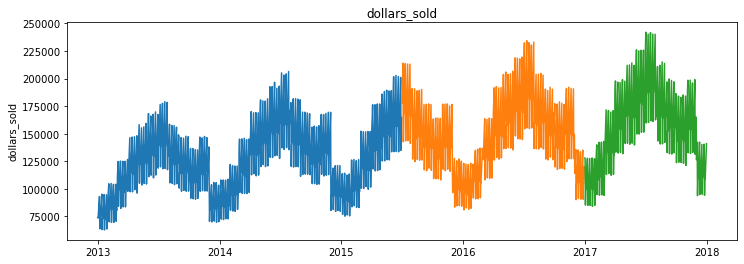

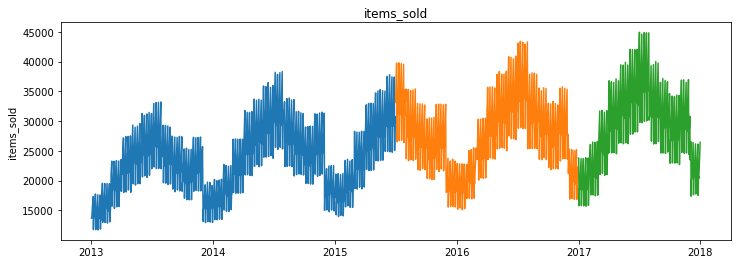

In [10]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.

`evaluate()` will compute the Mean Squared Error and the Root Mean Squared Error to evaluate. 

In [11]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var]))) # actual dollar sold compared to predicted dollar sold
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance.

In [12]:
def plot_and_eval(target_var):
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, "-- RMSE: {:.0f}".format(rmse))
    plt.show()

Write `append_eval_df(model_type)`

In [13]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Making Predictions

### Last observed value

#### Make Predictions

In [14]:
items = train['items_sold'][-1:][0] #Looking at just the last value
dollars = round(train['dollars_sold'][-1:][0],2) #Looking at just the last value

yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, 
                       index = validate.index)

print(yhat_df.shape)
yhat_df.head(2)

(547, 2)


,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,30703.0,164573.2
2015-07-03 00:00:00+00:00,30703.0,164573.2


547 values matches the size of the validate set. With this first prediction run, we are comparing the results of using a baseline prediction of last observed value to the actual values in the validate set.

#### Plot actual vs. Predicted Values

dollars_sold -- RMSE: 35402


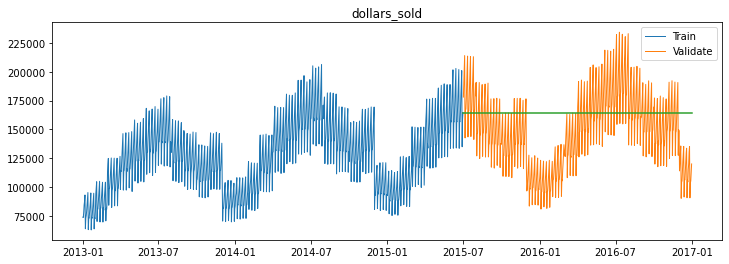

items_sold -- RMSE: 6621


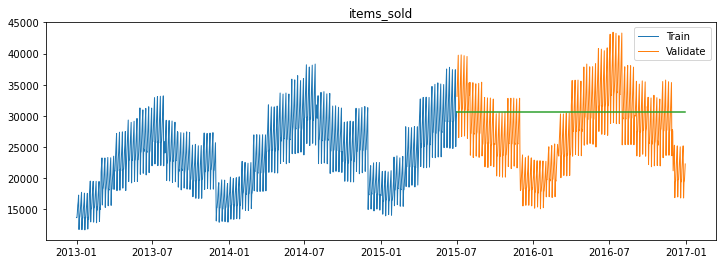

In [15]:
for col in train.columns:
    plot_and_eval(col)

#### Evaluate

In [16]:
for col in train.columns:
    eval_df = append_eval_df(model_type='last_observed_value', 
                             target_var = col)

In [17]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402
1,last_observed_value,items_sold,6621


### Simple Average

#### Make Predictions

In [18]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'items_sold': [items],
                            'dollars_sold': [dollars],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [19]:
yhat_df.head(2)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,23717.94,127517.85
2015-07-03 00:00:00+00:00,23717.94,127517.85


In [20]:
yhat_df.shape

(547, 2)

#### Plot Actual vs. Predicted Values



dollars_sold -- RMSE: 39664


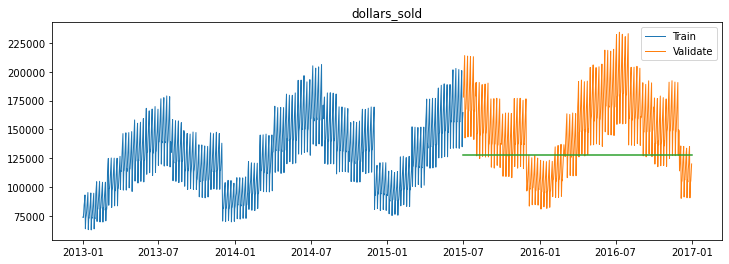

items_sold -- RMSE: 7378


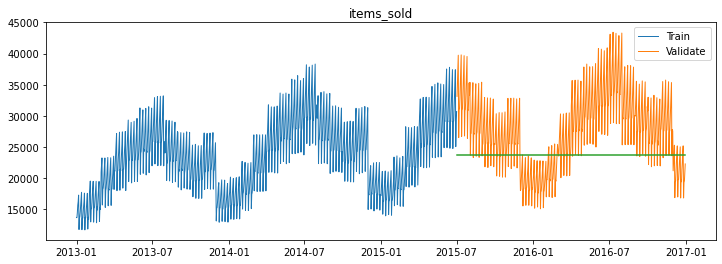

In [21]:
for col in train.columns:
    plot_and_eval(col)

#### Evaluate

In [22]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [23]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402
1,last_observed_value,items_sold,6621
2,simple_average,dollars_sold,39664
3,simple_average,items_sold,7378


### Moving Average

Using 30-day rolling average to predict forward.

In [24]:
train['dollars_sold'].rolling(30).mean() #It will start with 29 NaNs because we dont have 30 periods to compute an average

ds
2013-01-01 00:00:00+00:00              NaN
2013-01-02 00:00:00+00:00              NaN
2013-01-03 00:00:00+00:00              NaN
2013-01-04 00:00:00+00:00              NaN
2013-01-05 00:00:00+00:00              NaN
                                 ...      
2015-06-27 00:00:00+00:00    169307.076000
2015-06-28 00:00:00+00:00    170365.098000
2015-06-29 00:00:00+00:00    168925.788333
2015-06-30 00:00:00+00:00    167925.392000
2015-07-01 00:00:00+00:00    168957.912000
Name: dollars_sold, Length: 912, dtype: float64

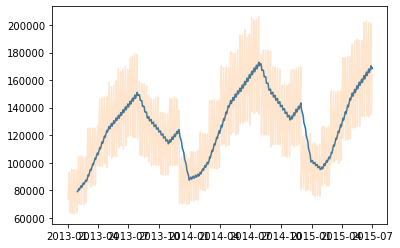

In [25]:
plt.plot(train['dollars_sold'].rolling(30).mean()) #Visualizing how rolling average changes over time
plt.plot(train['dollars_sold'], alpha = .2)

In [26]:
print(train['dollars_sold'].head(30).mean()) # mean of the first 30 entries
print(train['dollars_sold'].rolling(30).mean()[29]) #rolling average entry at index 29 matches the mean of the first 30 entries

78937.69766666666
78937.69766666666


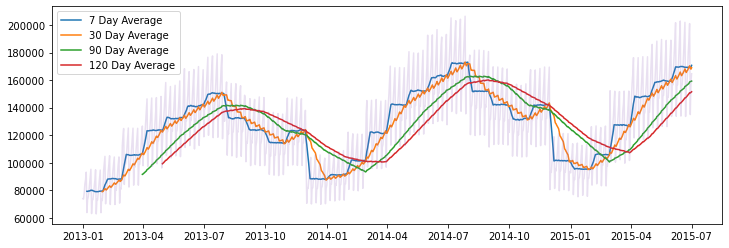

In [27]:
plt.figure(figsize=(12,4))
plt.plot(train['dollars_sold'].rolling(7).mean(), label = '7 Day Average')
plt.plot(train['dollars_sold'].rolling(30).mean(), label = '30 Day Average')
plt.plot(train['dollars_sold'].rolling(90).mean(), label = '90 Day Average')
plt.plot(train['dollars_sold'].rolling(120).mean(), label = '120 Day Average')
plt.plot(train['dollars_sold'], alpha = .2)
plt.legend()

#### Make Predictions

In [28]:
period = 30

dollars = round(train['dollars_sold'].rolling(period).mean()[-1], 2)
dollars

168957.91

In [29]:
items = round(train['items_sold'].rolling(period).mean()[-1], 2)
items

31432.77

In [30]:
yhat_df = make_predictions()
yhat_df.head()

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,31432.77,168957.91
2015-07-03 00:00:00+00:00,31432.77,168957.91
2015-07-04 00:00:00+00:00,31432.77,168957.91
2015-07-05 00:00:00+00:00,31432.77,168957.91
2015-07-06 00:00:00+00:00,31432.77,168957.91


#### Plot Actual vs. Predicted Values

dollars_sold -- RMSE: 37378


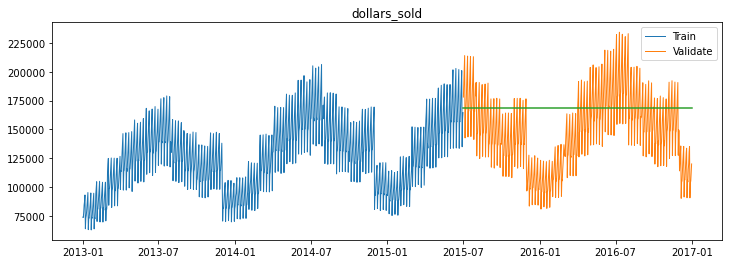

items_sold -- RMSE: 6954


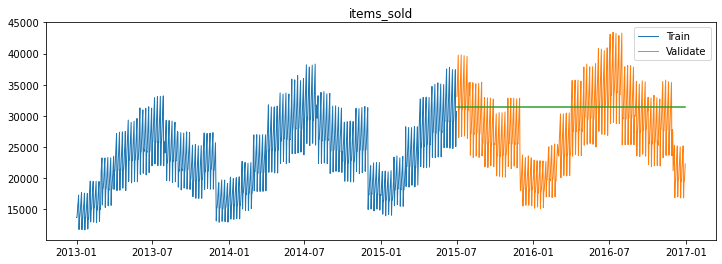

In [31]:
for col in train.columns:
    plot_and_eval(col)

#### Evaluate

In [32]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', target_var = col)
    
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402
1,last_observed_value,items_sold,6621
2,simple_average,dollars_sold,39664
3,simple_average,items_sold,7378
4,30d_moving_avg,dollars_sold,37378
5,30d_moving_avg,items_sold,6954


#### Trying additional moving average periods

In [140]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train['items_sold'].rolling(p).mean().iloc[-1], 2)
    dollars = round(train['dollars_sold'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'items_sold'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'dollars_sold'
                            )

In [141]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402
1,last_observed_value,items_sold,6621
2,simple_average,dollars_sold,39664
3,simple_average,items_sold,7378
4,30d_moving_avg,dollars_sold,37378
5,30d_moving_avg,items_sold,6954
6,1d moving average,items_sold,6621
7,1d moving average,dollars_sold,35402
8,4d moving average,items_sold,6592
9,4d moving average,dollars_sold,35515


In [142]:
eval_df.sort_values(by='rmse', ascending = True).head(1)

,model_type,target_var,rmse
16,104d moving average,items_sold,6101


### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).
  - to the average: "Im going to apply a weight to the moving average and as it gets closer to current its going to have a higher weight"
  - to the slope: "The trend that has happened over the last week is much more important or telling of the future than the trend that happened a year ago."

α
 / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
 
β
 / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.
 
#### Seasonal Decomposition

First lets take a look at the seasonal decomposition for each target

In [143]:
import statsmodels.api as sm

dollars_sold 



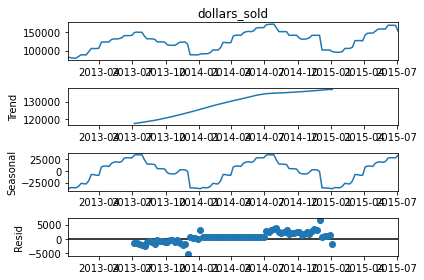

items_sold 



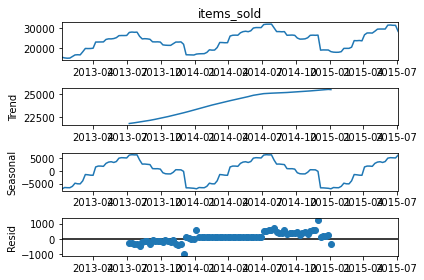

In [149]:
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

#### Basic Holt's Linear Trend

#### Make Predictions

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

Holt:

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
- damped o = True/False: with Holt, forecasts will increase or decrease indefinitely into the future. To avoid this, use the Damped trend method which has a damping parameter 0 < o < 1.

fit:

- smoothing_level (α): value between (0,1)
- smoothing_slope (β): value between (0,1)

In [152]:
for col in train.columns:
    model = Holt(train[col], exponential=False) #exponential= False because its pretty linear
    model = model.fit(optimized = True)
    yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [153]:
yhat_df.head()

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,31805.37,171009.91
2015-07-03 00:00:00+00:00,31841.16,171202.04
2015-07-04 00:00:00+00:00,31876.96,171394.18
2015-07-05 00:00:00+00:00,31912.75,171586.31
2015-07-06 00:00:00+00:00,31948.55,171778.45


#### Plot Actual vs. Predicted Values

dollars_sold -- RMSE: 84496


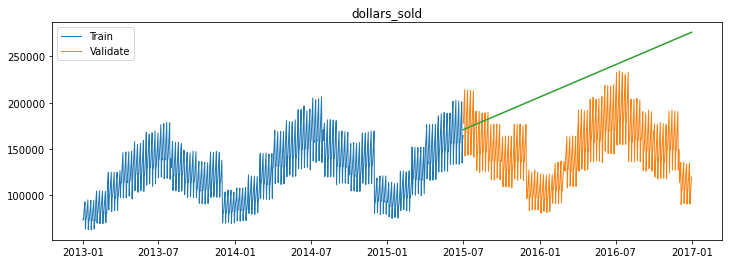

items_sold -- RMSE: 15727


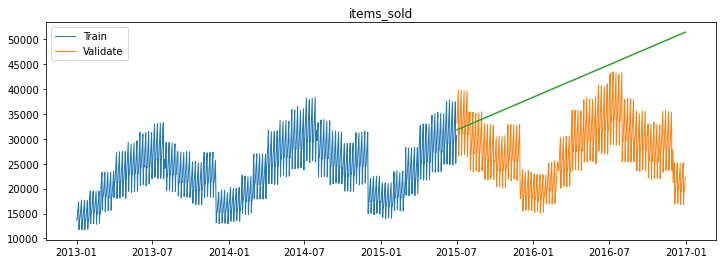

In [154]:
for col in train.columns:
    plot_and_eval(target_var = col)

#### Evaluate

In [155]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts_optimized', target_var = col)

In [156]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402
1,last_observed_value,items_sold,6621
2,simple_average,dollars_sold,39664
3,simple_average,items_sold,7378
4,30d_moving_avg,dollars_sold,37378
5,30d_moving_avg,items_sold,6954
6,1d moving average,items_sold,6621
7,1d moving average,dollars_sold,35402
8,4d moving average,items_sold,6592
9,4d moving average,dollars_sold,35515


Let's do another model, changing some hyperparameters

In [158]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped =True) #exponential= False because its pretty linear
    model = model.fit(optimized = True)
    yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

dollars_sold -- RMSE: 44226


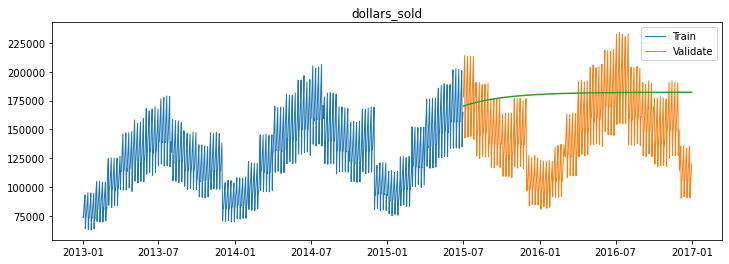

items_sold -- RMSE: 8225


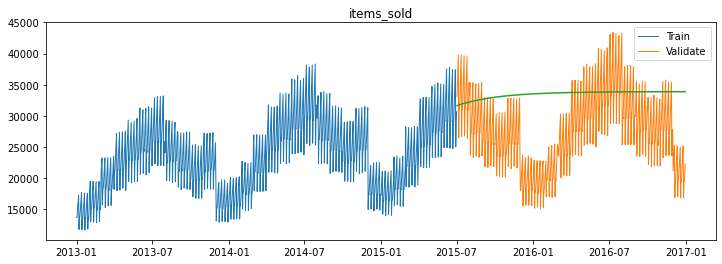

In [159]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [160]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts_optimized_damped', target_var = col)

In [161]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402
1,last_observed_value,items_sold,6621
2,simple_average,dollars_sold,39664
3,simple_average,items_sold,7378
4,30d_moving_avg,dollars_sold,37378
5,30d_moving_avg,items_sold,6954
6,1d moving average,items_sold,6621
7,1d moving average,dollars_sold,35402
8,4d moving average,items_sold,6592
9,4d moving average,dollars_sold,35515


In [174]:
for col in train.columns:
    model = Holt(train[col], exponential=False) #exponential= False because its pretty linear
    model = model.fit(smoothing_level=.1, smoothing_slope=.1, optimized=False)
    yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

dollars_sold -- RMSE: 34700


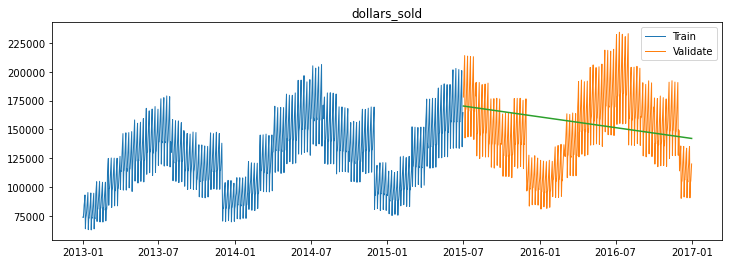

items_sold -- RMSE: 6464


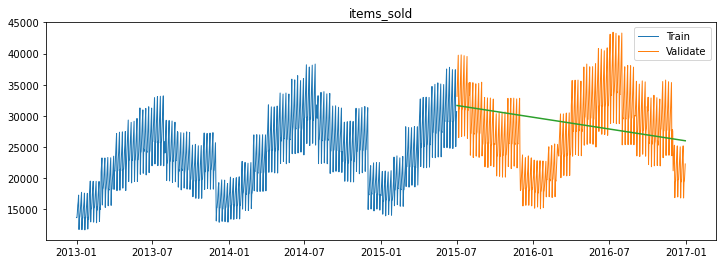

In [175]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [176]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts_.1', target_var = col)

In [177]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402
1,last_observed_value,items_sold,6621
2,simple_average,dollars_sold,39664
3,simple_average,items_sold,7378
4,30d_moving_avg,dollars_sold,37378
5,30d_moving_avg,items_sold,6954
6,1d moving average,items_sold,6621
7,1d moving average,dollars_sold,35402
8,4d moving average,items_sold,6592
9,4d moving average,dollars_sold,35515


## Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day.

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence.

In the below example:

1. Compute the 365 average year over year differences from 2013 through 2015 
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for.

**Re-split Data**

In [178]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

(1095, 2)
(365, 2)
(365, 2)


In [179]:
train.head()

,dollars_sold,items_sold
ds,,
2013-01-01 00:00:00+00:00,73844.01,13696.0
2013-01-02 00:00:00+00:00,73570.58,13678.0
2013-01-03 00:00:00+00:00,78169.48,14488.0
2013-01-04 00:00:00+00:00,84467.73,15677.0
2013-01-05 00:00:00+00:00,87621.85,16237.0


#### Make Predictions

In [180]:
train.diff(365)

,dollars_sold,items_sold
ds,,
2013-01-01 00:00:00+00:00,NaN,NaN
2013-01-02 00:00:00+00:00,NaN,NaN
2013-01-03 00:00:00+00:00,NaN,NaN
2013-01-04 00:00:00+00:00,NaN,NaN
2013-01-05 00:00:00+00:00,NaN,NaN
...,...,...
2015-12-27 00:00:00+00:00,10605.96,1951.0
2015-12-28 00:00:00+00:00,-36765.99,-6963.0
2015-12-29 00:00:00+00:00,18886.81,3515.0


In [181]:
train.diff(365).mean() # The average year over year difference

dollars_sold    11751.250493
items_sold       2185.813699
dtype: float64

In [182]:
# What if we add that average to 2015?
train['2015'] + train.diff(365).mean()

,dollars_sold,items_sold
ds,,
2015-01-01 00:00:00+00:00,104337.620493,19411.813699
2015-01-02 00:00:00+00:00,112870.770493,20904.813699
2015-01-03 00:00:00+00:00,118245.300493,21983.813699
2015-01-04 00:00:00+00:00,125496.760493,23286.813699
2015-01-05 00:00:00+00:00,88551.940493,16420.813699
...,...,...
2015-12-27 00:00:00+00:00,136877.110493,25453.813699
2015-12-28 00:00:00+00:00,96048.700493,17754.813699
2015-12-29 00:00:00+00:00,110354.000493,20588.813699


In [183]:
yhat_df = train['2015'] + train.diff(365).mean()

In [184]:
# Let's peek into the prediction we will make for 1/1/2016
# by comparing the predicted value (2015 value + year-over-year average diff)
# to the actual 2016 value
pd.concat([yhat_df.head(1), validate.head(1)]) #The top row is the prediction, the 2nd row is the actual

,dollars_sold,items_sold
ds,,
2015-01-01 00:00:00+00:00,104337.620493,19411.813699
2016-01-01 00:00:00+00:00,107875.260000,20158.000000


In [185]:
# Set yhat_df to index of validate
yhat_df.index = validate.index

yhat_df.describe()

,dollars_sold,items_sold
count,365.000000,365.000000
mean,152236.991370,28314.271233
std,31264.033981,5816.407123
min,87009.270493,16153.813699
25%,128679.520493,23977.813699
50%,150024.320493,27913.813699
75%,177535.990493,33022.813699
max,225791.620493,41979.813699


In [186]:
yhat_df.head()

,dollars_sold,items_sold
ds,,
2016-01-01 00:00:00+00:00,104337.620493,19411.813699
2016-01-02 00:00:00+00:00,112870.770493,20904.813699
2016-01-03 00:00:00+00:00,118245.300493,21983.813699
2016-01-04 00:00:00+00:00,125496.760493,23286.813699
2016-01-05 00:00:00+00:00,88551.940493,16420.813699


In [187]:
yhat_df.shape

(365, 2)

#### Plot and Evaluate

dollars_sold -- RMSE: 28087


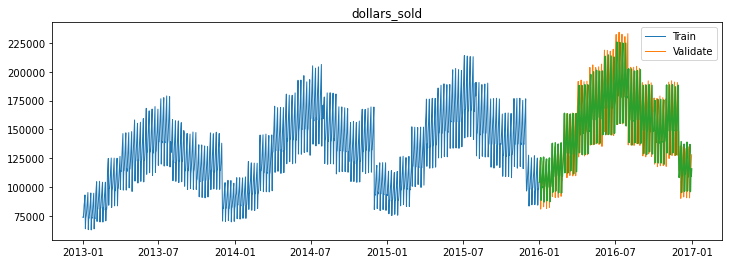

items_sold -- RMSE: 5223


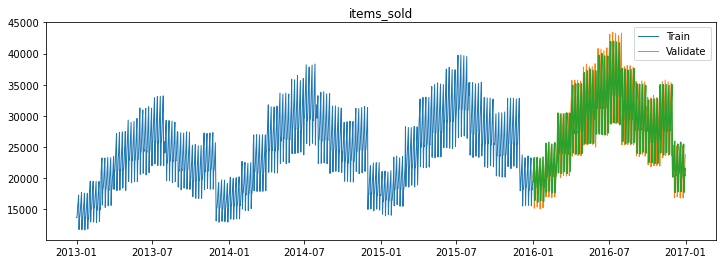

In [188]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'Previous_year', target_var = col)

# Conclusion

In [191]:
dollars_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]
items_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

In [192]:
eval_df[eval_df.rmse == dollars_min_rmse]

,model_type,target_var,rmse
24,Previous_year,dollars_sold,28087


In [193]:
eval_df[eval_df.rmse == items_min_rmse]

,model_type,target_var,rmse
25,Previous_year,items_sold,5223


In [194]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [195]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label = 'validate')
    plt.plot(test[target_var], label = 'test')
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

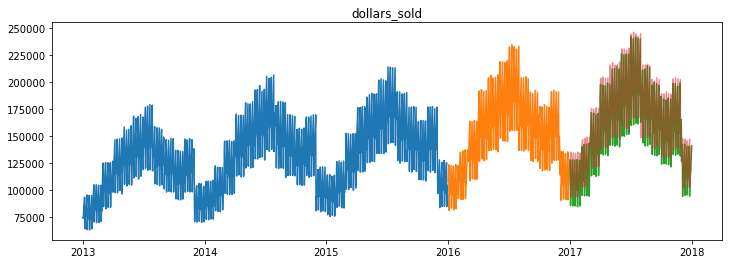

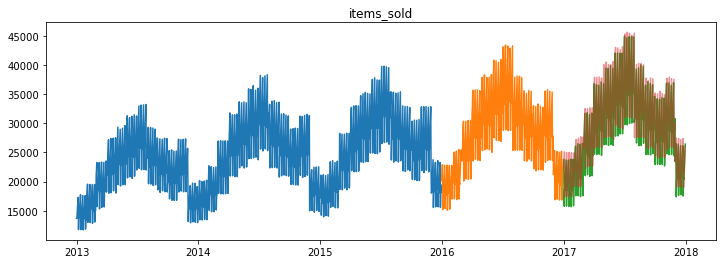

In [196]:
for col in train.columns:
    final_plot(col)

In [202]:
test_dollars_rmse = sqrt(mean_squared_error(test['dollars_sold'], 
                                            yhat_df['dollars_sold']))
test_items_rmse = sqrt(mean_squared_error(test['items_sold'], 
                                            yhat_df['items_sold']))

In [203]:
print(test_dollars_rmse, test_items_rmse)

27114.786014988113 5040.989142541608


In [204]:
# To predict 2018
yhat_df = test + train.diff(365).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

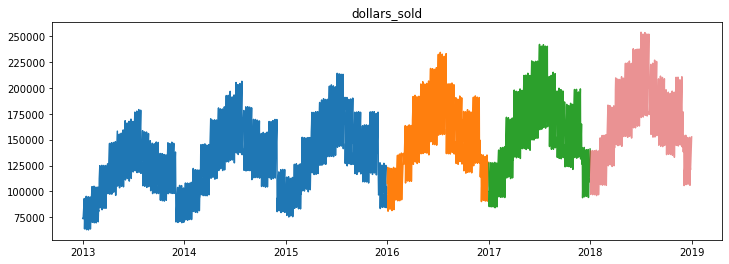

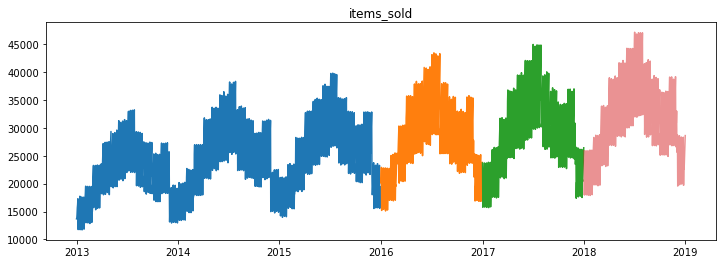

In [205]:
for col in train.columns:
    final_plot(col)

# EXERCISES

Using saas.csv or log data from API usage or store_item_sales

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total monthly sales for a single store and/or item by creating a model using prophet.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.

### EXERCISE ONE
Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [206]:
df = acquire.get_store_data()
df = prepare.prep_store_data(df)
df.head()

,quantity,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,sales_total
sale_date,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,10.92
2013-01-01 00:00:00+00:00,26.0,211817,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,218.40
2013-01-01 00:00:00+00:00,27.0,832657,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,125.55
2013-01-01 00:00:00+00:00,54.0,213643,15000 San Pedro Ave,San Antonio,8,TX,78232,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,453.60
2013-01-01 00:00:00+00:00,35.0,215469,735 SW Military Dr,San Antonio,9,TX,78221,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,294.00
